<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/sparse_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Autoencoder

Unlike traditional autoencoders, which aim to replicate the input data, sparse autoencoders incorporate a sparsity constraint, encouraging the network to activate only a small number of neurons in the hidden layer. This sparsity constraint helps extract meaningful features and representations from the input data, making the network more robust and efficient in capturing essential patterns. Sparse autoencoders find applications in various domains, such as image and signal processing, where learning compact and meaningful representations is crucial for tasks like classification and reconstruction.

In [1]:
# Install the library

!pip install rapidae

In [3]:
from keras import utils
from rapidae.data import load_MNIST
from rapidae.models.base import SparseEncoder, SparseDecoder
from rapidae.models import AE
from rapidae.pipelines import TrainingPipeline
from rapidae.evaluate import plot_reconstructions

### Data

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten digit images.

Train and test data are flattened since the first layer of the encoder we are going to use is a Dense layer.

In [4]:
# Load dataset
data = load_MNIST()

# Flatten and normalize data
x_train = data["x_train"].reshape(data["x_train"].shape[0], -1) / 255
x_test = data["x_test"].reshape(data["x_test"].shape[0], -1) / 255

# Obtain number of clasess
n_classes = len(set(data["y_train"]))

2024-04-16 11:33:34 [INFO]: Downloading train-images-idx3-ubyte.gz...
2024-04-16 11:33:34 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-04-16 11:33:34 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-04-16 11:33:34 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-04-16 11:33:35 [INFO]: Deleting MNIST data...


### Model


In [7]:
# Model creation
model = AE(input_dim=x_train.shape[1],
           latent_dim=32, 
           encoder=SparseEncoder, 
           decoder=SparseDecoder)

2024-04-16 11:36:00 [INFO]: Using provided encoder
2024-04-16 11:36:00 [INFO]: Encoder is a class, initializing...
2024-04-16 11:36:00 [INFO]: Using provided decoder
2024-04-16 11:36:00 [INFO]: Decoder is a class, initializing...


### Training

In the next cell a TrainingPipeline is created. This pipeline is in responsible for setting the training hyperparameters for the autoencoder such as the number of epochs, the batch size, the learning rate...

The model is trained by calling the pipeline and passing it the training set and the labels.

In [9]:
pipe = TrainingPipeline(name='sparse_ae_MNIST',
                        model=model, 
                        num_epochs=20, 
                        learning_rate=0.01)

trained_model = pipe(x=x_train)

2024-04-16 11:36:22 [INFO]: +++ sparse_ae_MNIST +++
2024-04-16 11:36:22 [INFO]: Creating folder in ./output_dir/sparse_ae_MNIST_2024-04-16_11-36
2024-04-16 11:36:22 [INFO]: 
TRAINING STARTED
	Backend: tensorflow
	Eager mode: False
	Validation data available: False
	Callbacks set: ['EarlyStopping', 'ModelCheckpoint'] 



Epoch 1/20


2024-04-16 11:36:23.458145: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.



Epoch 1: loss improved from inf to 0.05904, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16_11-36/model.weights.h5
469/469 - 13s - 27ms/step - loss: 0.0590
Epoch 2/20

Epoch 2: loss improved from 0.05904 to 0.02704, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16_11-36/model.weights.h5
469/469 - 19s - 41ms/step - loss: 0.0270
Epoch 3/20

Epoch 3: loss improved from 0.02704 to 0.01612, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16_11-36/model.weights.h5
469/469 - 10s - 22ms/step - loss: 0.0161
Epoch 4/20

Epoch 4: loss improved from 0.01612 to 0.01233, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16_11-36/model.weights.h5
469/469 - 11s - 23ms/step - loss: 0.0123
Epoch 5/20

Epoch 5: loss improved from 0.01233 to 0.01046, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16_11-36/model.weights.h5
469/469 - 18s - 39ms/step - loss: 0.0105
Epoch 6/20

Epoch 6: loss improved from 0.01046 to 0.00929, saving model to ./output_dir/sparse_ae_MNIST_2024-04-16

2024-04-16 11:40:10 [INFO]: Restoring best model
2024-04-16 11:40:10 [INFO]: Best model restored


### Evaluation

Once the model is trained, we can call it on the test set and compare the reconstructed images to check its performance.

 25/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2024-04-16 11:40:23.003317: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


2024-04-16 11:40:24.643487: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


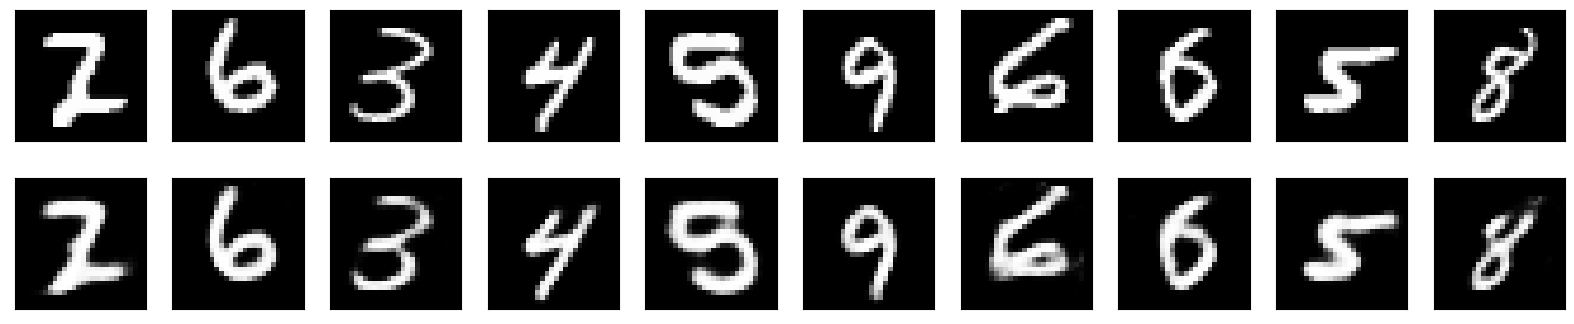

In [11]:
outputs = trained_model.predict(x_test)

plot_reconstructions(x_test, outputs['x_recon'])